In [114]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.optimize import curve_fit
from lmfit import Minimizer, Parameters, report_fit
import seaborn as sns

sns.set(color_codes=True, style="white")

### Load Data

In [115]:
folder = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-in-HOPS_condensates/paper_figure_plots/interaction_kinetics_lncRNA"
label1 = "THOR, 2x"
label2 = "THOR$\Delta$, 2x"
fname1 = "colocalization_AIO_concat-THOR_2x.csv"
fname2 = "colocalization_AIO_concat-THORdel_2x.csv"
color_1 = "#0C4DA2"
color_2 = "#4C90D2"
palette = [color_1, color_2]
os.chdir(folder)

In [116]:
df1 = pd.read_csv(fname1)
df2 = pd.read_csv(fname2)

### Functions

In [117]:
def get_dwell_times(array_in_condensate, array_trackID):
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )

    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1

    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )

    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))

    # Calculate the durations of each True event
    dwell_times = []
    for i in range(len(change_indices) - 1):
        if array_in_condensate[change_indices[i]]:
            dwell_times.append(change_indices[i + 1] - change_indices[i])

    return np.array(dwell_times)


def calc_R2(ydata, yfit):
    # residual sum of squares (ss_tot)
    residuals = ydata - yfit
    ss_res = np.sum(residuals**2)
    # total sum of squares (ss_tot)
    ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
    # r_squared-value
    r_squared = 1 - (ss_res / ss_tot)

    return r_squared


def cdf_lmfit_dual(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    a1 = params["a1"]
    a2 = params["a2"]
    k1 = params["k1"]
    k2 = params["k2"]
    model = 1 - a1 * np.exp(-k1 * t) - a2 * np.exp(-k2 * t)
    return model - data


def cdf_lmfit_single(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    a = params["a1"]
    k = params["k1"]
    model = 1 - a * np.exp(-k * t)
    return model - data


def fit_CDF_dual(dwell_times):
    bins = 200
    binrange = (0, 10)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins

    # create a set of Parameters
    params = Parameters()
    params.add("a1", min=0, max=1, value=0.8)
    params.add("a2", expr="1-a1")
    params.add("k1", min=2, max=8, value=5)
    params.add("k2", min=0.03, max=2, value=0.1)  # min=ln2/0.1

    # do fit, with the default leastsq algorithm
    minner = Minimizer(cdf_lmfit_dual, params, fcn_args=(bin_centers, cumulative_hist))
    result = minner.minimize()
    report_fit(result)

    a1 = result.params["a1"].value
    a2 = result.params["a2"].value
    k1 = result.params["k1"].value
    k2 = result.params["k2"].value
    a1_se = result.params["a1"].stderr
    a2_se = result.params["a2"].stderr
    k1_se = result.params["k1"].stderr
    k2_se = result.params["k2"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    return {
        "a1": a1,
        "a2": a2,
        "k1": k1,
        "k2": k2,
        "a1_se": a1_se,
        "a2_se": a2_se,
        "k1_se": k1_se,
        "k2_se": k2_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }


def fit_CDF_single(dwell_times):
    bins = 200
    binrange = (0, 10)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins

    # create a set of Parameters
    params = Parameters()
    params.add("a1", min=0, max=1, value=0.8)
    params.add("k1", min=0.03, max=7, value=5)  # min=ln2/0.1

    # do fit, with the default leastsq algorithm
    minner = Minimizer(
        cdf_lmfit_single, params, fcn_args=(bin_centers, cumulative_hist)
    )
    result = minner.minimize()
    report_fit(result)

    a1 = result.params["a1"].value
    k1 = result.params["k1"].value
    a1_se = result.params["a1"].stderr
    k1_se = result.params["k1"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    return {
        "a1": a1,
        "k1": k1,
        "a1_se": a1_se,
        "k1_se": k1_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }

### Dwell time distributions

In [118]:
dwell_times_1 = (
    get_dwell_times(df1["InCondensate"].to_numpy(), df1["RNA_trackID"].to_numpy()) * 0.1
)  # unit s
dwell_times_2 = (
    get_dwell_times(df2["InCondensate"].to_numpy(), df2["RNA_trackID"].to_numpy()) * 0.1
)  # unit s
data = pd.concat(
    [
        pd.DataFrame({"dwell_time": dwell_times_1, "label": label1}),
        pd.DataFrame({"dwell_time": dwell_times_2, "label": label2}),
    ],
    ignore_index=True,
)

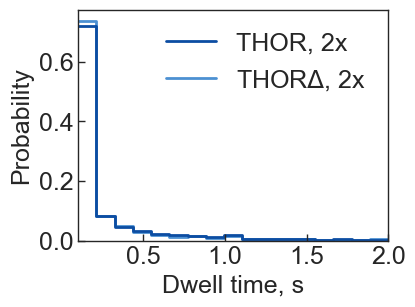

In [119]:
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="dwell_time",
    hue="label",
    palette=palette,
    bins=17,
    binrange=(0.1, 2),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    # cumulative=True,
)
plt.xlim(0.1, 2)
sns.move_legend(ax, 1, title=None, frameon=False, fontsize=18)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "dwell-histo.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

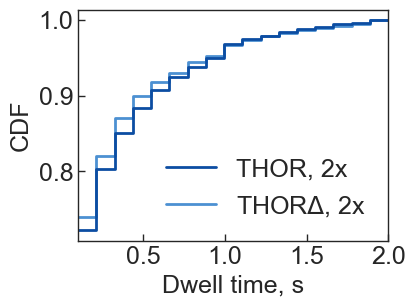

In [128]:
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="dwell_time",
    hue="label",
    palette=palette,
    bins=17,
    binrange=(0.1, 2),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
plt.xlim(0.1, 2)
sns.move_legend(ax, 4, title=None, frameon=False, fontsize=18)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("CDF", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "dwell-cdf.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### Fit to CDF

In [121]:
dwell_times_1 = (
    get_dwell_times(df1["InCondensate"].to_numpy(), df1["RNA_trackID"].to_numpy()) * 0.1
)  # unit s
dwell_times_2 = (
    get_dwell_times(df2["InCondensate"].to_numpy(), df2["RNA_trackID"].to_numpy()) * 0.1
)  # unit s

In [122]:
print(label1)
results_dual_1 = fit_CDF_dual(dwell_times_1)
results_single_1 = fit_CDF_single(dwell_times_1)

THOR, 2x
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 200
    # variables        = 3
    chi-square         = 0.15930601
    reduced chi-square = 8.0866e-04
    Akaike info crit   = -1421.04914
    Bayesian info crit = -1411.15418
[[Variables]]
    a1:  0.92455761 +/- 0.02135467 (2.31%) (init = 0.8)
    a2:  0.07544239 +/- 0.02135467 (28.31%) == '1-a1'
    k1:  4.12241551 +/- 0.19562374 (4.75%) (init = 5)
    k2:  0.49004978 +/- 0.12901224 (26.33%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, k2) = -0.887
    C(a1, k1) = -0.796
    C(k1, k2) = 0.640
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 200
    # variables        = 2
    chi-square         = 0.20418803
    reduced chi-square = 0.00103125
    Akaike info crit   = -1373.40627
    Bayesian info crit = -1366.80964
[[Variables]]
    a1:  1.00000000 +/- 0.03208082 (3.21%) (init = 0.8)

In [123]:
print(label2)
results_dual_2 = fit_CDF_dual(dwell_times_2)
results_single_2 = fit_CDF_single(dwell_times_2)

THOR$\Delta$, 2x
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 200
    # variables        = 3
    chi-square         = 0.17309903
    reduced chi-square = 8.7868e-04
    Akaike info crit   = -1404.44175
    Bayesian info crit = -1394.54680
[[Variables]]
    a1:  0.93443329 +/- 0.02059799 (2.20%) (init = 0.8)
    a2:  0.06556671 +/- 0.02059799 (31.42%) == '1-a1'
    k1:  4.29722818 +/- 0.20677514 (4.81%) (init = 5)
    k2:  0.47365135 +/- 0.14241752 (30.07%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, k2) = -0.880
    C(a1, k1) = -0.780
    C(k1, k2) = 0.623
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 200
    # variables        = 2
    chi-square         = 0.21140310
    reduced chi-square = 0.00106769
    Akaike info crit   = -1366.46119
    Bayesian info crit = -1359.86455
[[Variables]]
    a1:  1.00000000 +/- 0.00729281 (0.73%) (ini

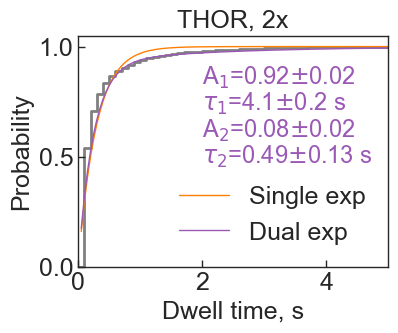

In [126]:
# For first dataset
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=dwell_times_1,
    color="gray",
    bins=100,
    binrange=(0, 5),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
# plot single fit
plt.plot(
    results_single_1["bin_centers"],
    results_single_1["yfit"],
    color="#FF7F00",
    linestyle="-",
    label="Single exp",
    lw=1,
)
# plot dual fit
plt.plot(
    results_dual_1["bin_centers"],
    results_dual_1["yfit"],
    color="#9B59B6",
    linestyle="-",
    label="Dual exp",
    lw=1,
)
# add text
left = 2
top = 0.83
gap = 0.12
plt.text(
    left,
    top,
    "A$_1$="
    + "{:.2f}".format(round(results_dual_1["a1"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_1["a1_se"], 2)),
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 1,
    r"$\tau_1$="
    + "{:.1f}".format(round(results_dual_1["k1"], 1))
    + r"$\pm$"
    + "{:.1f}".format(round(results_dual_1["k1_se"], 1))
    + " s",
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 2,
    "A$_2$="
    + "{:.2f}".format(round(results_dual_1["a2"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_1["a2_se"], 2)),
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 3,
    r"$\tau_2$="
    + "{:.2f}".format(round(results_dual_1["k2"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_1["k2_se"], 2))
    + " s",
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
# adjust other param
plt.legend(frameon=False, loc=4, fontsize=18)
plt.xlim(0, 5)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.title(label1, fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "compare_exp_fits-THOR_2x.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

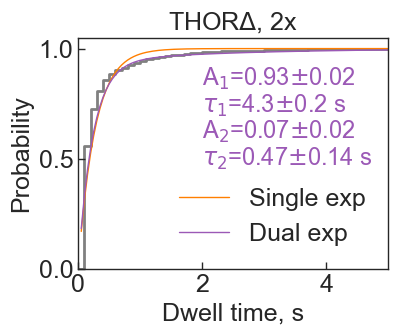

In [127]:
# For second dataset
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=dwell_times_2,
    color="gray",
    bins=100,
    binrange=(0, 5),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
# plot single fit
plt.plot(
    results_single_2["bin_centers"],
    results_single_2["yfit"],
    color="#FF7F00",
    linestyle="-",
    label="Single exp",
    lw=1,
)
# plot dual fit
plt.plot(
    results_dual_2["bin_centers"],
    results_dual_2["yfit"],
    color="#9B59B6",
    linestyle="-",
    label="Dual exp",
    lw=1,
)
# add text
left = 2
top = 0.83
gap = 0.12
plt.text(
    left,
    top,
    "A$_1$="
    + "{:.2f}".format(round(results_dual_2["a1"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_2["a1_se"], 2)),
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 1,
    r"$\tau_1$="
    + "{:.1f}".format(round(results_dual_2["k1"], 1))
    + r"$\pm$"
    + "{:.1f}".format(round(results_dual_2["k1_se"], 1))
    + " s",
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 2,
    "A$_2$="
    + "{:.2f}".format(round(results_dual_2["a2"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_2["a2_se"], 2)),
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 3,
    r"$\tau_2$="
    + "{:.2f}".format(round(results_dual_2["k2"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_2["k2_se"], 2))
    + " s",
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
# adjust other param
plt.legend(frameon=False, loc=4, fontsize=18)
plt.xlim(0, 5)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.title(label2, fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "compare_exp_fits-THORdel_2x.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)